### Copy Move Detection using FFT

In [1]:
# import cv2
# import numpy as np
# import pywt
# from skimage.metrics import structural_similarity as ssim
# import json

# def fft_magnitude(patch):
#     """
#     Compute the magnitude of the 2D Fourier transform and take its logarithm.
#     """
#     f_transform = np.fft.fft2(patch)
#     f_transform = np.fft.fftshift(f_transform)
#     magnitude = np.abs(f_transform)
#     return np.log(1 + magnitude)

# def wavelet_transform(patch):
#     """
#     Compute the approximation coefficients of the 2D Wavelet transform.
#     """
#     coeffs = pywt.wavedec2(patch, 'haar')
#     return coeffs[0]

# def compare_noise(patch1, patch2):
#     """
#     Compare noise patterns between two patches using SSIM.
#     """
#     return ssim(patch1, patch2)


# def resize_roi(roi, target_size):
#     """
#     Resize the ROI to a target size while preserving the aspect ratio.
#     """
#     h, w = roi.shape
#     aspect_ratio = w / h
#     if w > h:
#         new_w = target_size
#         new_h = int(new_w / aspect_ratio)
#     else:
#         new_h = target_size
#         new_w = int(new_h * aspect_ratio)
#     resized_roi = cv2.resize(roi, (new_w, new_h))
#     return resized_roi

# def detect_anomalies(roi_list, threshold=0.5):
#     """
#     Detect anomalies in noise distribution within the provided ROIs.
#     """
#     noise_distributions = []

#     for roi in roi_list:
#         # Resize the ROI to a consistent size
#         target_size = 32  # Set your desired size
#         roi = resize_roi(roi, target_size)

#         noise_distribution = fft_magnitude(roi)  # Use Fourier or wavelet here
#         noise_distributions.append(noise_distribution)

#     anomalies = []

#     for i, noise1 in enumerate(noise_distributions):
#         for j, noise2 in enumerate(noise_distributions):
#             if i != j:
#                 difference = compare_noise(noise1, noise2)
#                 if difference > threshold:
#                     anomalies.append((i, j))

#     return anomalies


# def read_json(path, display=False):
#     import pprint as pprint
#     with open(path, 'r') as f:
#         data = json.load(f)
    
#     if display:
#         pprint(data)
#     return data


# def draw_bounding_boxes(image, data, display=False, write=False):
#     roi_list = []
#     for item in data[0]['words']:
#         x1, y1 = item['boundingBox'][0:2]
#         x2, y2 = item['boundingBox'][-4:-2]
#         # image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
#         # print(x1, y1)
#         roi = image[y1:y2, x1:x2]
#         roi_list.append([x1, y1, x2, y2])
        
#         # cv2.imshow('roi', roi)

#         # k = cv2.waitKey()
#         # if k == 27:
#         #     cv2.destroyAllWindows()
#         #     break
            
#         # cv2.destroyAllWindows()

#         #     roi_list.append(roi) 

#         # if write:
#         #     cv2.imwrite('sample.jpg', image)

#         # if display:
#         #     plt.imshow(image)
#         #     plt.show()
#         #     return
#         # return image

#     return roi_list
        

# json_path = '/home/acer/Downloads/Sample-Veggi-Bill-Modified.json'
# img_path = '/home/acer/Downloads/Sample-Veggi-Bill-Modified.jpg'


# image = cv2.imread(img_path)
# data = read_json(json_path)
# suspected_bounding_boxes = draw_bounding_boxes(image, data, display=True, write=True)



# # List of ROIs (Region of Interest) from your suspected bounding boxes
# roi_list = []






# # Load and preprocess the ROIs
# for bbox in suspected_bounding_boxes:
#     x1, y1, x2, y2 = bbox
#     roi = image[y1:y2, x1:x2]
#     roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

#     # Apply noise reduction or other preprocessing if necessary

#     roi_list.append(roi)

# # Set the anomaly detection threshold
# threshold = 0.5

# # Detect anomalies in the noise distributions of ROIs
# anomalies = detect_anomalies(roi_list, threshold)

# # Print the coordinates of ROIs with anomalies
# for anomaly in anomalies:
#     roi1_idx, roi2_idx = anomaly
#     print(f"Anomaly detected between ROI {roi1_idx} and ROI {roi2_idx}. Coordinates: {suspected_bounding_boxes[roi1_idx]} and {suspected_bounding_boxes[roi2_idx]}")


In [2]:
from helpers import read_json, draw_bounding_boxes
import cv2
import numpy as np
import pywt
from skimage.metrics import structural_similarity as ssim


In [3]:

def fft_magnitude(patch):
    """
    Compute the magnitude of the 2D Fourier transform with padding to retain shape.
    """
    # Get the current shape of the patch
    h, w = patch.shape

    # Find the maximum dimension
    max_dim = max(h, w)

    # Create a square canvas with side length max_dim
    canvas = np.zeros((max_dim, max_dim), dtype=patch.dtype)

    # Calculate the position to paste the patch
    x_pos = (max_dim - w) // 2
    y_pos = (max_dim - h) // 2

    # Paste the patch onto the canvas
    canvas[y_pos:y_pos + h, x_pos:x_pos + w] = patch

    # Compute the magnitude of the 2D Fourier transform and take its logarithm
    f_transform = np.fft.fft2(canvas)
    f_transform = np.fft.fftshift(f_transform)
    magnitude = np.abs(f_transform)
    return np.log(1 + magnitude)



def wavelet_transform(patch):
    """
    Compute the approximation coefficients of the 2D Wavelet transform.
    """
    coeffs = pywt.wavedec2(patch, 'haar')
    return coeffs[0]

def compare_noise(patch1, patch2, win_size):
    if patch1.shape == patch2.shape:
        data_range = 255  # Adjust as needed for your image range
        return ssim(patch1, patch2, win_size=win_size, data_range=data_range)
    else:
        return 0.0

def resize_roi(roi, target_size):
    """
    Resize the ROI to a target size while preserving the aspect ratio.
    """
    h, w = roi.shape
    aspect_ratio = w / h
    if w > h:
        new_w = target_size
        new_h = int(new_w / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(new_h * aspect_ratio)
    resized_roi = cv2.resize(roi, (new_w, new_h))
    return resized_roi

def detect_anomalies(roi_list, threshold=0.5, win_size=7):
    noise_distributions = []

    for roi in roi_list:
        target_size = 32
        roi = resize_roi(roi, target_size)
        noise_distribution = fft_magnitude(roi)  # Use Fourier or wavelet here
        noise_distributions.append(noise_distribution)
    
    anomalies = []

    for i, noise1 in enumerate(noise_distributions):
        for j, noise2 in enumerate(noise_distributions):
            if i != j:
                difference = compare_noise(noise1, noise2, win_size)
                if difference > threshold:
                    anomalies.append((i, j))

    return anomalies

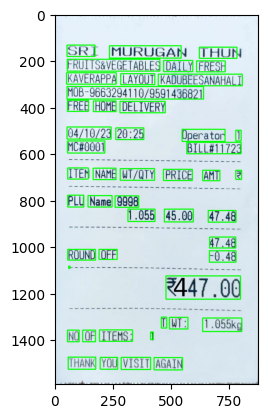

Anomaly detected between ROI 0 and ROI 1.
Anomaly detected between ROI 0 and ROI 2.
Anomaly detected between ROI 0 and ROI 3.
Anomaly detected between ROI 0 and ROI 4.
Anomaly detected between ROI 0 and ROI 5.
Anomaly detected between ROI 0 and ROI 6.
Anomaly detected between ROI 0 and ROI 7.
Anomaly detected between ROI 0 and ROI 8.
Anomaly detected between ROI 0 and ROI 9.
Anomaly detected between ROI 0 and ROI 10.
Anomaly detected between ROI 0 and ROI 11.
Anomaly detected between ROI 0 and ROI 12.
Anomaly detected between ROI 0 and ROI 13.
Anomaly detected between ROI 0 and ROI 14.
Anomaly detected between ROI 0 and ROI 15.
Anomaly detected between ROI 0 and ROI 16.
Anomaly detected between ROI 0 and ROI 17.
Anomaly detected between ROI 0 and ROI 18.
Anomaly detected between ROI 0 and ROI 19.
Anomaly detected between ROI 0 and ROI 20.
Anomaly detected between ROI 0 and ROI 21.
Anomaly detected between ROI 0 and ROI 22.
Anomaly detected between ROI 0 and ROI 23.
Anomaly detected bet

In [4]:

json_path = '/home/acer/Downloads/Sample-Veggi-Bill-Modified.json'
img_path = '/home/acer/Downloads/Sample-Veggi-Bill-Modified.jpg'

image = cv2.imread(img_path)
data = read_json(json_path)
image_copy = image.copy()
bounding_boxes = draw_bounding_boxes(image_copy, data, display=True, write=False, retrieve_boxes=True)


roi_list = []
for bbox in bounding_boxes:
    x1, y1, x2, y2 = bbox

    roi = image[y1:y2, x1:x2]
    roi_list.append(roi)


# Find the maximum dimensions of ROIs in the list
max_height, max_width = max(roi.shape[:2] for roi in roi_list)


resized_roi_list = []
for roi in roi_list:
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    # Resize the ROIs to the maximum dimensions and retain shape
    resized_roi = cv2.resize(roi, (max_width, max_height))
    resized_roi_list.append(resized_roi)

threshold = 0.5

anomalies = detect_anomalies(resized_roi_list, threshold, win_size=7)

if anomalies is not None:
    for anomaly in anomalies:
        roi1_idx, roi2_idx = anomaly
        print(f"Anomaly detected between ROI {roi1_idx} and ROI {roi2_idx}.")
else:
    print("No anomalies detected.")